In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [77]:
# ------ 1. Preparing data ------
df = pd.read_csv('data/raw/icd.csv', delimiter=';')

# 1.1 filter
df = df[['time', '2_variable_label', '2_variable_attribute_code', '2_variable_attribute_label','2_variable_code', 'value']]

df.rename(columns={
    'time': 'year',
    '2_variable_label': 'icd_form_type',
    '2_variable_code': 'icd_form',
    '2_variable_attribute_code': 'icd_code',
    '2_variable_attribute_label': 'diagnosis_category',
    'value': 'count',
}, inplace=True)



# 1.2 type conversion of column 'value' since it is a object type
mapping = str.maketrans({',': '.', '-': '0'})
df['count'] = df['count'].astype(str).str.translate(mapping)
df['count'] = pd.to_numeric(df['count'], errors='raise')

# checks
print(df.shape)
df.head()

(20250, 6)


,year,icd_form_type,icd_code,diagnosis_category,icd_form,count
0,2021,ICD-10 (1-Steller) Nebendiagnosen,ICD10-D00-D48,Übrige Neubildungen,ICD10D,594620
1,2019,ICD-10 (1-Steller) Nebendiagnosen,ICD10-J00-J99,Krankheiten des Atmungssystems,ICD10D,4914020
2,2018,ICD-10 (1-Steller) Nebendiagnosen,ICD10-M00-M99,Krankh. d. Muskel-Skelett-Systems u.d.Bindegew...,ICD10D,3969546
3,2017,ICD-10 (1-Steller) Nebendiagnosen,ICD10-C00-C97,Bösartige Neubildungen,ICD10D,1845640
4,2016,ICD-10 (1-Steller) Nebendiagnosen,ICD10-K00-K93,Krankheiten des Verdauungssystems,ICD10D,4856484


In [78]:
df.notna().sum()
# df = df[df['diagnosis_category'] != 'Insgesamt']


year                  20250
icd_form_type         20250
icd_code              20240
diagnosis_category    20250
icd_form              20250
count                 20250
dtype: int64

Seems like we found a culprit!
'icd_code' has some missing values
what to do with it?

In [79]:
df[df.isna().any(axis=1)]

,year,icd_form_type,icd_code,diagnosis_category,icd_form,count
49,2021,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,139788116
93,2019,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,120899995
124,2015,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,106318408
134,2022,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,139414834
173,2018,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,118003312
183,2016,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,111603570
200,2023,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,125171046
205,2024,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,121544729
210,2020,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,123731421
226,2017,ICD-10 (1-Steller) Nebendiagnosen,NaN,Insgesamt,ICD10D,115354906


In [80]:
# Basic strategy for handling missing values
df['icd_code'] = df['icd_code'].fillna('undefined')
df.notna().sum()

year                  20250
icd_form_type         20250
icd_code              20250
diagnosis_category    20250
icd_form              20250
count                 20250
dtype: int64

In [106]:
# need to pivot table to make it suitable for K-means
df_pivot = df.pivot_table(index='icd_code', columns='year', values='count', fill_value=0)

df_pivot.head()

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
icd_code,,,,,,,,,,
ICD10-A00,4.0,3.0,5.0,4.0,5.0,3.0,6.0,5.0,9.0,7.0
ICD10-A00-A09,240325.0,222012.0,228984.0,223137.0,217844.0,172682.0,164566.0,174410.0,183624.0,214010.0
ICD10-A00-B99,3165133.0,3294351.0,3387732.0,3413601.0,3481971.0,3299632.0,3364260.0,3308105.0,3293051.0,3281153.0
ICD10-A01,56.0,47.0,66.0,51.0,56.0,29.0,24.0,14.0,28.0,24.0
ICD10-A02,1450.0,1443.0,1474.0,1365.0,1524.0,1173.0,1090.0,1075.0,1177.0,1338.0


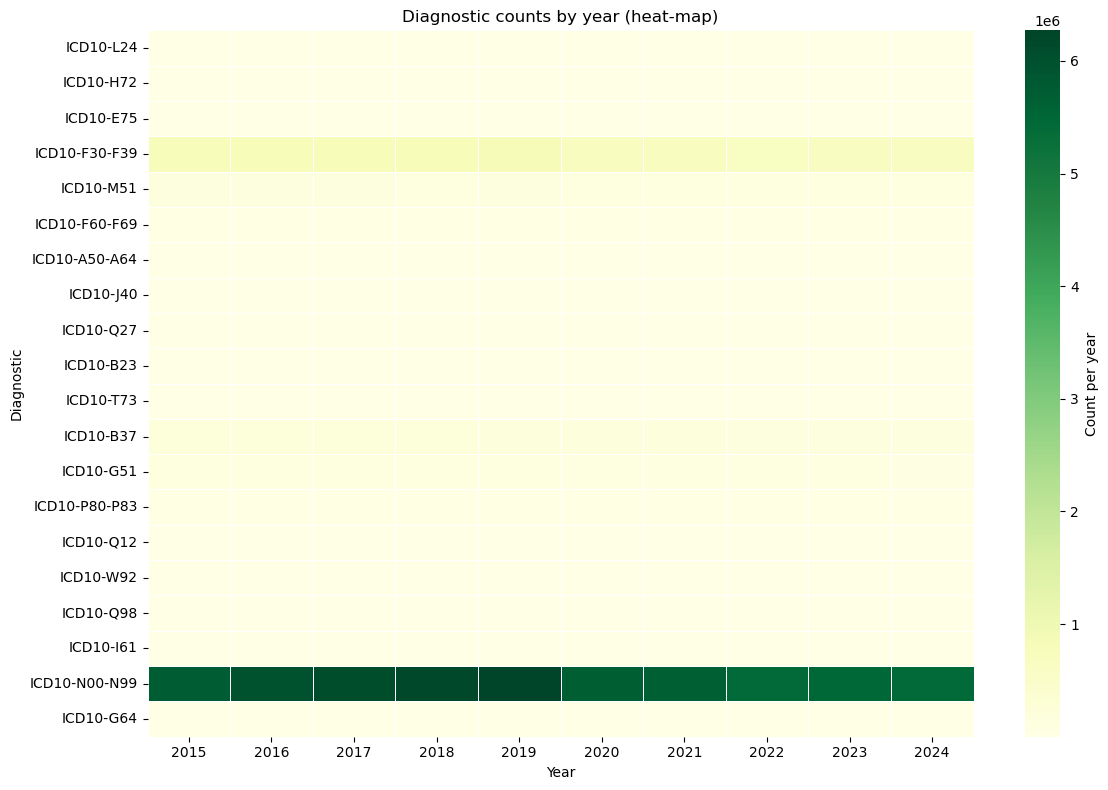

In [85]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot.sample(20),
            cmap='YlGn',
            linewidths=0.5,
            linecolor='white',
            cbar_kws={'label':'Count per year'},
            annot=False)          # set annot=True for numbers
plt.title('Diagnostic counts by year (heat‑map)')
plt.xlabel('Year')
plt.ylabel('Diagnostic')
plt.tight_layout()
plt.show()

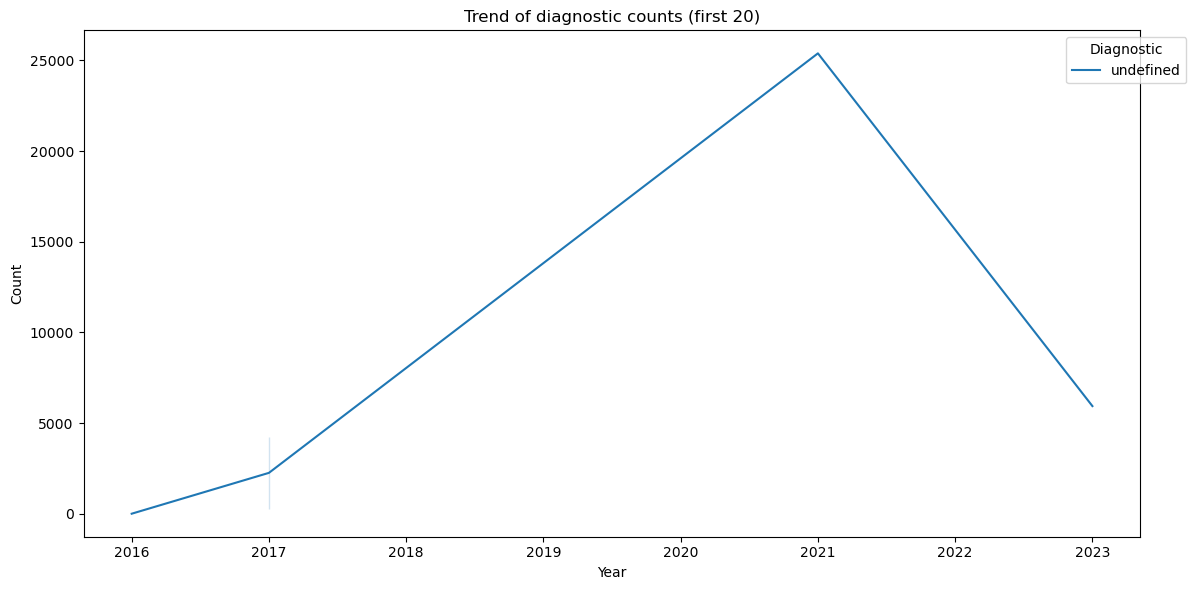

In [72]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.sample(5),
             x='year',
             y='count',
             hue='icd_code',
             legend='full',
             markers=True,
             lw=1.5)
plt.title('Trend of diagnostic counts (first 20)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Diagnostic', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [73]:

X_cluster = df_pivot.values  # numpy representation (matrix)